In [35]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
import torch
from torch import nn

from lib import data
from lib import sar
from lib import io

from torch.utils.data import Dataset
from loguru import logger
from lib.datamodules.components.patches import PatchesDataset
from lib.datamodules.patches import PatchesDataModule

# data params


In [36]:
base_path = "/home/rlx/data/sar-recovery"
date_train = '20100520'
date_test  = '20120720'

window_size = 7

# load data


In [37]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

# create log matrices


In [38]:
lcm3x3tr = torch.tensor(sar.matlog(cmtr))
lcm3x3ts = torch.tensor(sar.matlog(cmts))
lcm2x2tr = torch.tensor(sar.matlog(cmtr[...,1:3, 1:3]))
lcm2x2ts = torch.tensor(sar.matlog(cmts[...,1:3, 1:3]))
lcm3x3tr.shape, lcm2x2tr.shape

(torch.Size([628, 228, 3, 3]), torch.Size([628, 228, 2, 2]))

# split mask


In [5]:
h, w, _, _ = cmtr.shape
splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)
TRAIN, TEST, VAL = 0,1,2

# use data loader

In [6]:
dp = PatchesDataModule(
        input_train_image  = lcm2x2tr,
        output_train_image = lcm3x3tr,
        input_test_image   = lcm2x2ts,
        output_test_image  = lcm3x3ts,
        input_val_image    = lcm2x2ts,
        output_val_image   = lcm3x3ts,
        patch_size  = 15,
        batch_size  = 32,
        splitmask   = splitmask_bands,
        shuffle_train = True,
        shuffle_test  = True,
        shuffle_val   = True
)

2024-03-31 11:29:43.995 | INFO     | lib.datamodules.patches:__init__:52 - PatchesDataset              patch_size=15  splitmask_dims=(628, 228)
original split proportions: train=0.713  test=0.143  val=0.143
patch split proportions:    train=0.714  test=0.143  val=0.143
        


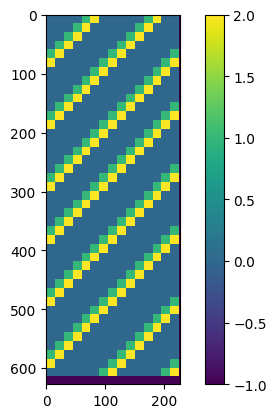

In [7]:
dp.train_dataset.plot_split()

In [8]:
dts = dp.test_dataloader()

In [9]:
# normally one would iterate over the full dataset
# here, we stop at the first batch to inspect it
for item in dts:
    break

In [10]:
# observe that a batch is a dictionary of patches and their coordinates in the original image
item.keys()

dict_keys(['input_patch', 'output_patch', 'patch_coords'])

In [11]:
# batches of shape: [batch_size, patch_size, patch_size, ...]
item['input_patch'].shape, item['output_patch'].shape, item['patch_coords'].shape

(torch.Size([32, 15, 15, 2, 2]),
 torch.Size([32, 15, 15, 3, 3]),
 torch.Size([32, 2]))

# check batches


In [12]:
ia,ib = np.percentile(dp.hparams.input_test_image[:,:,0,0].real, [1,99])
oa,ob = np.percentile(dp.hparams.output_test_image[:,:,0,0].real, [1,99])

### collated patches (real part of 0,0 input, real part of 0,0 output)

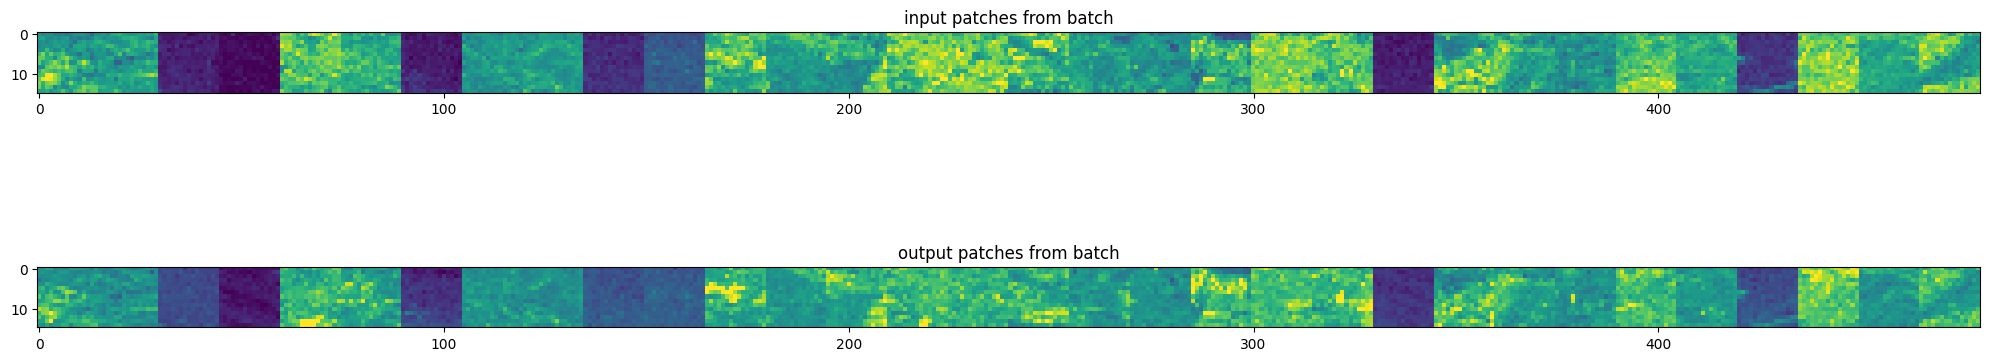

In [28]:
for ax,i in subplots(2, n_cols=1, usizex=20):
    if i==0:
        input_img_from_batch = np.concatenate([i for i in item['input_patch'][:,:,:,0,0].numpy()])
        plt.imshow(input_img_from_batch.T.real, vmin=ia, vmax=ib)
        plt.title("input patches from batch")
    if i==1:
        output_img_from_batch = np.concatenate([i for i in item['output_patch'][:,:,:,0,0].numpy()])
        plt.imshow(output_img_from_batch.T.real, vmin=oa, vmax=ob)
        plt.title("output patches from batch")

### image content from the original image (real part of 0,0 input, real part of 0,0 output)

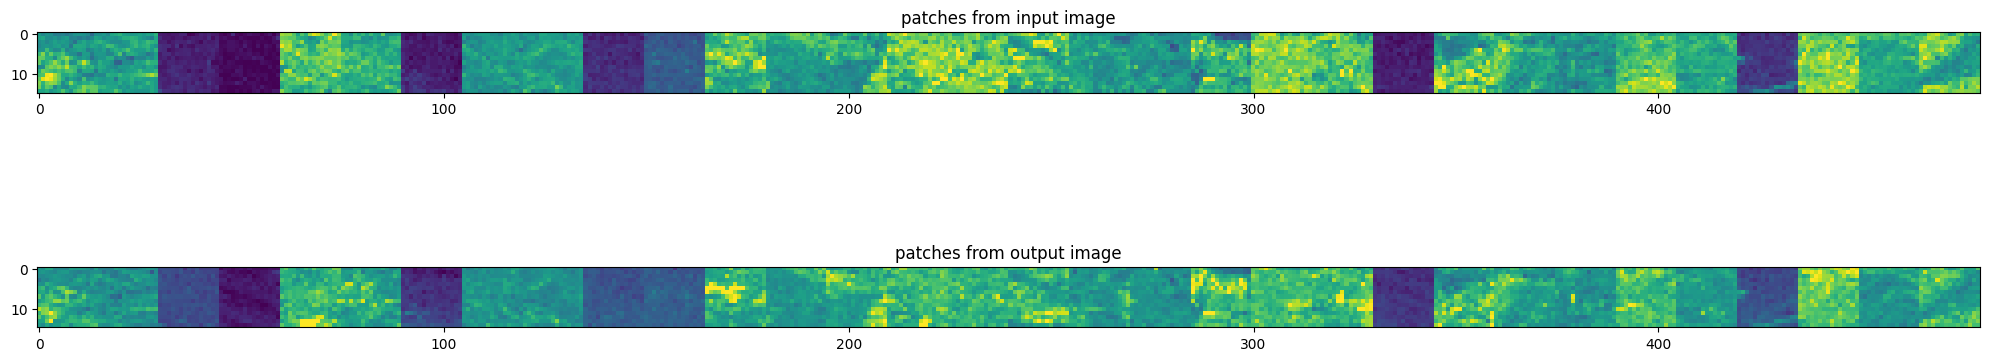

In [29]:
p = dp.hparams.patch_size
for ax,i in subplots(2, n_cols=1, usizex=20):
    if i==0:
        input_patchset_from_img = np.concatenate([lcm2x2ts[y:y+p,x:x+p,0,0].real for y,x in item['patch_coords']])
        plt.imshow(input_patchset_from_img.T, vmin=ia, vmax=ib)
        plt.title("patches from input image")
    if i==1:
        output_patchset_from_img = np.concatenate([lcm3x3ts[y:y+p,x:x+p,0,0].real for y,x in item['patch_coords']])
        plt.imshow(output_patchset_from_img.T, vmin=oa, vmax=ob)
        plt.title("patches from output image")

In [32]:
# check all values are the same
np.allclose(input_img_from_batch, input_patchset_from_img), \
np.allclose(output_img_from_batch, output_patchset_from_img)

(True, True)

## locations in original image of batch elements


In [33]:
z = np.zeros(cmts.shape[:2])
for y,x in item['patch_coords'].numpy():
    z[y:y+p, x:x+p] = 1

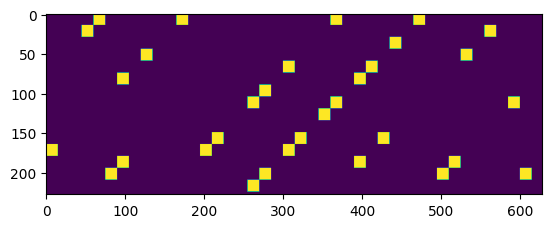

In [34]:
plt.imshow(z.T)